# Project: Age regression from brain MRI

Predicting the age of patient from a brain MRI scan can have diagnostic value for a number of diseases that may cause structural changes and potential damage to the brain. A discrepancy between the predicted age and the real, chronological age of a patient might indicate the presence of disease. This requires an accurate predictor of brain age which may be learned from a set of healthy reference subjects, given their brain MRI data and their actual age.

The objective for the project is to implement different supervised learning approaches for age regression from brain MRI. 


### Getting started and familiarise ourselves with the data
]There is a set of 52 subjects to be used in part A to develop an image segmentation method (47 for training, 5 for validation). We then use 500 subjects for training and cross-validation of age regression approaches in part A, B and C. A remaining set of 100 subjects is used to test the final age prediction accuracy and will be made available towards the end of the coursework.

### Running on Colab or Azure

In [ ]:
! pip install SimpleITK==1.2.2 
! wget https://www.doc.ic.ac.uk/~bglocker/teaching/notebooks/brainage-data.zip
! unzip brainage-data.zip

In [ ]:
# data directory
data_dir = 'data/brain_age/'

### Running on DoC lab machines


Loading the meta data of the entire population, that is the data containing information about the subject IDs, their age, and gender.

In [ ]:
# Read the meta data using pandas
import pandas as pd
meta_data_all = pd.read_csv(data_dir + 'meta/meta_data_all.csv')
meta_data_all.head() # show the first five data entries

Population statistics.

In [ ]:
%matplotlib inline

import matplotlib.pyplot as plt
import seaborn as sns

meta_data = meta_data_all

sns.catplot(x="gender_text", data=meta_data, kind="count")
plt.title('Gender distribution')
plt.xlabel('Gender')
plt.show()

sns.distplot(meta_data['age'], bins=[10,20,30,40,50,60,70,80,90])
plt.title('Age distribution')
plt.xlabel('Age')
plt.show()

plt.scatter(range(len(meta_data['age'])),meta_data['age'], marker='.')
plt.grid()
plt.xlabel('Subject')
plt.ylabel('Age')
plt.show()

### Set up a medical image viewer and import SimpleITK

In [ ]:
import numpy as np
import SimpleITK as sitk
import matplotlib.pyplot as plt

from ipywidgets import interact, fixed
from IPython.display import display

# Calculate parameters low and high from window and level
def wl_to_lh(window, level):
    low = level - window/2
    high = level + window/2
    return low,high

def display_image(img, x=None, y=None, z=None, window=None, level=None, colormap='gray', crosshair=False):
    # Convert SimpleITK image to NumPy array
    img_array = sitk.GetArrayFromImage(img)
    
    # Get image dimensions in millimetres
    size = img.GetSize()
    spacing = img.GetSpacing()
    width  = size[0] * spacing[0]
    height = size[1] * spacing[1]
    depth  = size[2] * spacing[2]
    
    if x is None:
        x = np.floor(size[0]/2).astype(int)
    if y is None:
        y = np.floor(size[1]/2).astype(int)
    if z is None:
        z = np.floor(size[2]/2).astype(int)
    
    if window is None:
        window = np.max(img_array) - np.min(img_array)
    
    if level is None:
        level = window / 2 + np.min(img_array)
    
    low,high = wl_to_lh(window,level)

    # Display the orthogonal slices
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(10, 4))

    ax1.imshow(img_array[z,:,:], cmap=colormap, clim=(low, high), extent=(0, width, height, 0))
    ax2.imshow(img_array[:,y,:], origin='lower', cmap=colormap, clim=(low, high), extent=(0, width,  0, depth))
    ax3.imshow(img_array[:,:,x], origin='lower', cmap=colormap, clim=(low, high), extent=(0, height, 0, depth))

    # Additionally display crosshairs
    if crosshair:
        ax1.axhline(y * spacing[1], lw=1)
        ax1.axvline(x * spacing[0], lw=1)
        ax2.axhline(z * spacing[2], lw=1)
        ax2.axvline(x * spacing[0], lw=1)
        ax3.axhline(z * spacing[2], lw=1)
        ax3.axvline(y * spacing[1], lw=1)

    plt.show()
    
def interactive_view(img):
    size = img.GetSize() 
    img_array = sitk.GetArrayFromImage(img)
    interact(display_image,img=fixed(img),
             x=(0, size[0] - 1),
             y=(0, size[1] - 1),
             z=(0, size[2] - 1),
             window=(0,np.max(img_array) - np.min(img_array)),
             level=(np.min(img_array),np.max(img_array)));

### Imaging data

Imaging data that is available for each subject, and retrieving data given a particular subject ID from the meta data.

Imaging data of subject CC110033 with age 24

MR Image (used in part A)


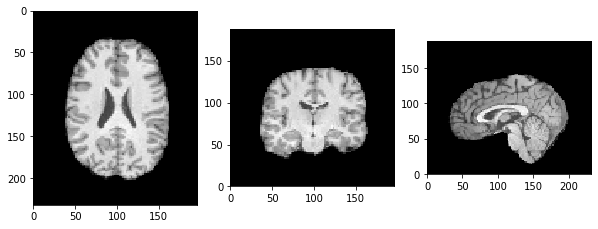

Brain mask (used in part A)


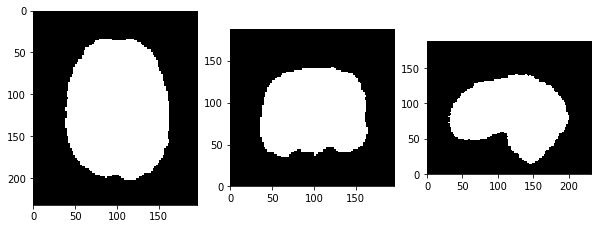

Spatially normalised grey matter maps (used in part B and C)


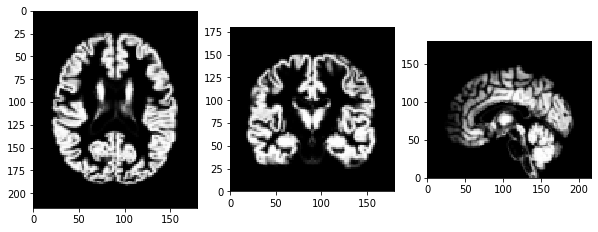

In [ ]:
# Subject with index 0
ID = meta_data['subject_id'][0]
age = meta_data['age'][0]

# Image
image_filename = data_dir + 'images/sub-' + ID + '_T1w_unbiased.nii.gz'
img = sitk.ReadImage(image_filename)

# Mask
mask_filename = data_dir + 'masks/sub-' + ID + '_T1w_brain_mask.nii.gz'
msk = sitk.ReadImage(mask_filename)

# Grey matter map
gm_filename = data_dir + 'greymatter/wc1sub-' + ID + '_T1w.nii.gz'
gm = sitk.ReadImage(gm_filename)

print('Imaging data of subject ' + ID + ' with age ' + str(age))

print('\nMR Image (used in part A)')
display_image(img, window=400, level=200)

print('Brain mask (used in part A)')
display_image(msk)

print('Spatially normalised grey matter maps (used in part B and C)')
display_image(gm)

## Part A: Volume-based regression using brain structure segmentation

The first approach aims to regress the age of a subject using the volumes of brain tissues as features. The brain structures include grey matter (GM), white matter (WM), and cerebrospinal fluid (CSF). It is known that with increasing age the ventricles enlarge (filled with CSF), while it is assumed that grey and white matter volume may decrease over time. However, as overall brain volume varies across individuals, taking the absolute volumes of tissues might not be predictive. Instead, relative volumes need to be computed as the ratios between each tissue volume and overall brain volume. To this end, a four-class (GM, WM, CSF, and background) brain segmentation needs to be implemented which will be trained using a total of 52 subjects (47 for training, 5 for validation). The segmentation method is then applied to the remaining 600 brain scans which will be used to train and test the age regression. Brain masks are provided which have been generated with a state-of-the-art neuroimaging brain extraction tool.


### TASK A-1: Brain tissue segmentation

CNN model implemented for brain tissue segmentation which can provide segmentations of GM, WM, and CSF. For this task (and only for this task), there is a subset of 52 subjects which are split into 47 images for training and 5 for validation. 

Applied segmentations to the 500 subjects later used for training the age regressor. Dice similarity coefficients calculated per tissue and compared predicted segmentations to the reference segmentations. 


#### Imports

In [ ]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm

#### Data Helpers

In [ ]:
def zero_mean_unit_var(image, mask):
    """Normalizes an image to zero mean and unit variance."""

    img_array = sitk.GetArrayFromImage(image)
    img_array = img_array.astype(np.float32)

    msk_array = sitk.GetArrayFromImage(mask)

    mean = np.mean(img_array[msk_array>0])
    std = np.std(img_array[msk_array>0])

    if std > 0:
        img_array = (img_array - mean) / std
        img_array[msk_array==0] = 0

    image_normalised = sitk.GetImageFromArray(img_array)
    image_normalised.CopyInformation(image)

    return image_normalised


def resample_image(image, out_spacing=(1.0, 1.0, 1.0), out_size=None, is_label=False, pad_value=0):
    """Resamples an image to given element spacing and output size."""

    original_spacing = np.array(image.GetSpacing())
    original_size = np.array(image.GetSize())

    if out_size is None:
        out_size = np.round(np.array(original_size * original_spacing / np.array(out_spacing))).astype(int)
    else:
        out_size = np.array(out_size)

    original_direction = np.array(image.GetDirection()).reshape(len(original_spacing),-1)
    original_center = (np.array(original_size, dtype=float) - 1.0) / 2.0 * original_spacing
    out_center = (np.array(out_size, dtype=float) - 1.0) / 2.0 * np.array(out_spacing)

    original_center = np.matmul(original_direction, original_center)
    out_center = np.matmul(original_direction, out_center)
    out_origin = np.array(image.GetOrigin()) + (original_center - out_center)

    resample = sitk.ResampleImageFilter()
    resample.SetOutputSpacing(out_spacing)
    resample.SetSize(out_size.tolist())
    resample.SetOutputDirection(image.GetDirection())
    resample.SetOutputOrigin(out_origin.tolist())
    resample.SetTransform(sitk.Transform())
    resample.SetDefaultPixelValue(pad_value)

    if is_label:
        resample.SetInterpolator(sitk.sitkNearestNeighbor)
    else:
        resample.SetInterpolator(sitk.sitkBSpline)

    return resample.Execute(image)


class ImageSegmentationDataset(Dataset):
    """Dataset for image segmentation."""

    def __init__(self, file_list_img, file_list_seg, file_list_msk, img_spacing, img_size):
        self.samples = []
        self.img_names = []
        self.seg_names = []
        for idx, _ in enumerate(tqdm(range(len(file_list_img)), desc='Loading Data')):
            img_path = file_list_img[idx]
            seg_path = file_list_seg[idx]
            msk_path = file_list_msk[idx]

            img = sitk.ReadImage(img_path, sitk.sitkFloat32)

            seg = sitk.ReadImage(seg_path, sitk.sitkInt64)

            msk = sitk.ReadImage(msk_path, sitk.sitkUInt8)

            #pre=processing
            img = zero_mean_unit_var(img, msk)
            img = resample_image(img, img_spacing, img_size, is_label=False)
            seg = resample_image(seg, img_spacing, img_size, is_label=True)
            msk = resample_image(msk, img_spacing, img_size, is_label=True)

            sample = {'img': img, 'seg': seg, 'msk': msk}

            self.samples.append(sample)
            self.img_names.append(os.path.basename(img_path))
            self.seg_names.append(os.path.basename(seg_path))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, item):
        sample = self.samples[item]

        image = torch.from_numpy(sitk.GetArrayFromImage(sample['img'])).unsqueeze(0)
        seg = torch.from_numpy(sitk.GetArrayFromImage(sample['seg'])).unsqueeze(0)
        msk = torch.from_numpy(sitk.GetArrayFromImage(sample['msk'])).unsqueeze(0)

        return {'img': image, 'seg': seg, 'msk': msk}

    def get_sample(self, item):
        return self.samples[item]

    def get_img_name(self, item):
        return self.img_names[item]

    def get_seg_name(self, item):
        return self.seg_names[item]\


#### Check that the GPU is up and running

In [ ]:
cuda_dev = '0' # GPU device 0 (can be changed if multiple GPUs are available)

use_cuda = torch.cuda.is_available()
device = torch.device("cuda:" + cuda_dev if use_cuda else "cpu")

print('Device: ' + str(device))
if use_cuda:
    print('GPU: ' + str(torch.cuda.get_device_name(int(cuda_dev))))        

Device: cuda:0
GPU: Tesla T4


#### Config and hyper-parameters

Here we set some default hyper-parameters and a configuration for the image resolution and others.


In [ ]:
rnd_seed = 0 # fixed random seed

img_size = [64, 64, 64]
img_spacing = [3, 3, 3]

num_epochs = 100
learning_rate = 0.001
batch_size = 2
val_interval = 10

num_classes = 4

out_dir = './output'

# Create output directory
if not os.path.exists(out_dir):
    os.makedirs(out_dir)


#### Loading and pre-processing of training and validation data

In [ ]:
meta_data_seg_train = pd.read_csv(data_dir + 'meta/meta_data_seg_train.csv')
ids_seg_train = list(meta_data_seg_train['subject_id'])
files_seg_img_train = [data_dir + 'images/sub-' + f + '_T1w_unbiased.nii.gz' for f in ids_seg_train]
files_seg_seg_train = [data_dir + 'segs_refs/sub-' + f + '_T1w_seg.nii.gz' for f in ids_seg_train]
files_seg_msk_train = [data_dir + 'masks/sub-' + f + '_T1w_brain_mask.nii.gz' for f in ids_seg_train]

meta_data_seg_val = pd.read_csv(data_dir + 'meta/meta_data_seg_val.csv')
ids_seg_val = list(meta_data_seg_val['subject_id'])
files_seg_img_val = [data_dir + 'images/sub-' + f + '_T1w_unbiased.nii.gz' for f in ids_seg_val]
files_seg_seg_val = [data_dir + 'segs_refs/sub-' + f + '_T1w_seg.nii.gz' for f in ids_seg_val]
files_seg_msk_val = [data_dir + 'masks/sub-' + f + '_T1w_brain_mask.nii.gz' for f in ids_seg_val]

We apply some standard pre-processing on the data such as intensity normalization (zero mean unit variance) and downsampling according to the configuration above.

In [ ]:
# LOAD VALIDATION DATA AS TRAINING FOR QUICK DEBUGGING
#dataset_train = ImageSegmentationDataset(files_seg_img_val, files_seg_seg_val, files_seg_msk_val, img_spacing, img_size)

# LOAD ACTUAL TRAINING DATA
dataset_train = ImageSegmentationDataset(files_seg_img_train, files_seg_seg_train, files_seg_msk_train, img_spacing, img_size)
dataloader_train = torch.utils.data.DataLoader(dataset_train, batch_size=batch_size, shuffle=True)

dataset_val = ImageSegmentationDataset(files_seg_img_val, files_seg_seg_val, files_seg_msk_val, img_spacing, img_size)
dataloader_val = torch.utils.data.DataLoader(dataset_val, batch_size=1, shuffle=False)

Loading Data: 100%|██████████| 5/5 [00:00<00:00,  5.28it/s]


#### Visualise training example

Just to check how a training image looks like after pre-processing.

Image: sub-CC221040_T1w_unbiased.nii.gz


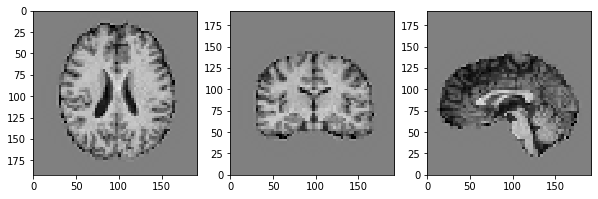

Segmentation


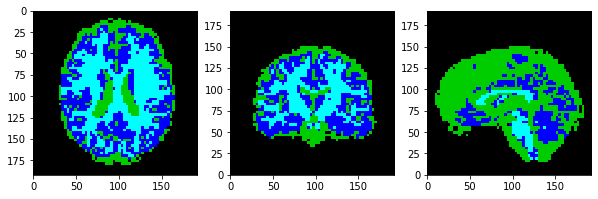

Mask


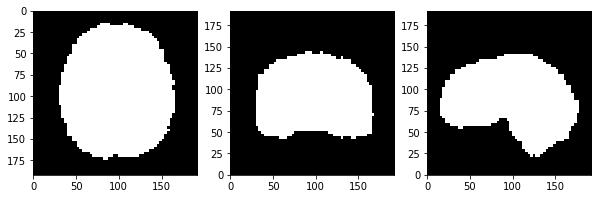

In [ ]:
sample = dataset_train.get_sample(0)
img_name = dataset_train.get_img_name(0)
seg_name = dataset_train.get_seg_name(0)
print('Image: ' + img_name)
display_image(sample['img'], window=5, level=0)
print('Segmentation')
display_image(sitk.LabelToRGB(sample['seg']))
print('Mask')
display_image(sample['msk'])

#### The Model

Designing a CNN model for brain segmentation. 

In [ ]:
class SimpleNet3D(nn.Module):
    def __init__(self, num_classes):
        super(SimpleNet3D, self).__init__()
        self.conv1 = nn.Conv3d(1, 18, kernel_size=3, padding=1)
        self.conv2 = nn.Conv3d(18, 36, kernel_size=3, padding=1)
        self.conv3 = nn.Conv3d(36, 54, kernel_size=3, padding=1)
        self.conv4 = nn.Conv3d(54, 27, kernel_size=1)
        self.conv5 = nn.Conv3d(27, num_classes, kernel_size=1)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = self.conv5(x)
        return F.softmax(x, dim=1)

In [ ]:
# SegNet3D based on U-Net architecture 

class SegNet3D(nn.Module):
    def __init__(self, num_classes):
        super(SegNet3D, self).__init__()
        self.conv1 = nn.Conv3d(1, 4, kernel_size=3, padding=1)
        self.conv2 = nn.Conv3d(4, 8, kernel_size=3, padding=1)
        
        # Downsample
        self.down = nn.Conv3d(8, 16, kernel_size=2, stride=2)        
        
        self.conv3 = nn.Conv3d(16, 32, kernel_size=3, padding=1)
        self.conv4 = nn.Conv3d(32, 32, kernel_size=3, padding=1)
        self.conv5 = nn.Conv3d(32, 16, kernel_size=3, padding=1)
        
        # Upsample (Transpose Convolution)
        self.up = nn.ConvTranspose3d(16, 8, kernel_size=2, stride=2)        
        
        self.conv6 = nn.Conv3d(8, 4, kernel_size=3, padding=1)
        self.conv7 = nn.Conv3d(4, num_classes, kernel_size=3, padding=1)

    def forward(self, x):
        x1 = F.relu(self.conv1(x))
        x1 = F.relu(self.conv2(x1))       
        x2 = self.down(x1)
        x2 = F.relu(self.conv3(x2))
        x2 = F.relu(self.conv4(x2))
        x2 = F.relu(self.conv5(x2))  

        # Skip connection:     
        x1 = self.up(x2) + x1
        
        x1 = F.relu(self.conv6(x1))
        x = self.conv7(x1)
        
        return x # cross-entropy loss expects raw logits and applies softmax

#### TRAINING

Implementation of a full training procedure including intermediate evaluation of the model on the validation data. 

START TRAINING...
+ TRAINING 	Epoch: 1 	Loss: 0.898290
--------------------------------------------------
+ VALIDATE 	Epoch: 1 	Loss: 0.873092 	Dice score:0.497179 	F1_score:0.853050


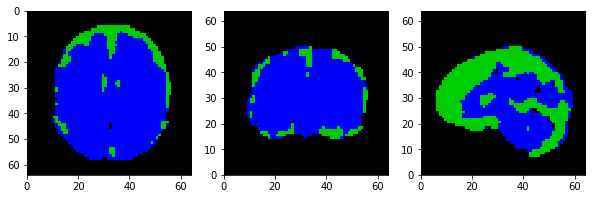

--------------------------------------------------
+ TRAINING 	Epoch: 2 	Loss: 0.825236
+ TRAINING 	Epoch: 3 	Loss: 0.852776
+ TRAINING 	Epoch: 4 	Loss: 0.827499
+ TRAINING 	Epoch: 5 	Loss: 0.821406
+ TRAINING 	Epoch: 6 	Loss: 0.808986
+ TRAINING 	Epoch: 7 	Loss: 0.819162
+ TRAINING 	Epoch: 8 	Loss: 0.805136
+ TRAINING 	Epoch: 9 	Loss: 0.807381
+ TRAINING 	Epoch: 10 	Loss: 0.810012
--------------------------------------------------
+ VALIDATE 	Epoch: 10 	Loss: 0.813079 	Dice score:0.734845 	F1_score:0.930423


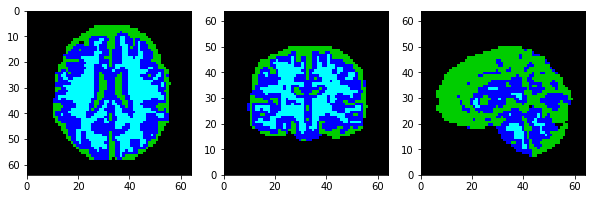

--------------------------------------------------
+ TRAINING 	Epoch: 11 	Loss: 0.807616
+ TRAINING 	Epoch: 12 	Loss: 0.812223
+ TRAINING 	Epoch: 13 	Loss: 0.797570
+ TRAINING 	Epoch: 14 	Loss: 0.814010
+ TRAINING 	Epoch: 15 	Loss: 0.806166
+ TRAINING 	Epoch: 16 	Loss: 0.806000
+ TRAINING 	Epoch: 17 	Loss: 0.829340
+ TRAINING 	Epoch: 18 	Loss: 0.805979
+ TRAINING 	Epoch: 19 	Loss: 0.796474
+ TRAINING 	Epoch: 20 	Loss: 0.813652
--------------------------------------------------
+ VALIDATE 	Epoch: 20 	Loss: 0.801767 	Dice score:0.780290 	F1_score:0.940584


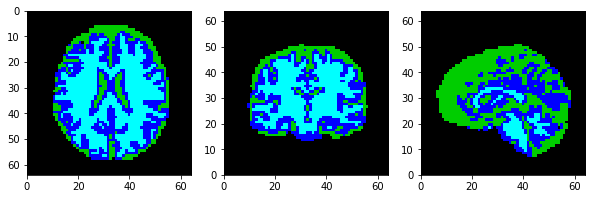

--------------------------------------------------
+ TRAINING 	Epoch: 21 	Loss: 0.818188
+ TRAINING 	Epoch: 22 	Loss: 0.815713
+ TRAINING 	Epoch: 23 	Loss: 0.793836
+ TRAINING 	Epoch: 24 	Loss: 0.805833
+ TRAINING 	Epoch: 25 	Loss: 0.803264
+ TRAINING 	Epoch: 26 	Loss: 0.795075
+ TRAINING 	Epoch: 27 	Loss: 0.788353
+ TRAINING 	Epoch: 28 	Loss: 0.798262
+ TRAINING 	Epoch: 29 	Loss: 0.794636
+ TRAINING 	Epoch: 30 	Loss: 0.795815
--------------------------------------------------
+ VALIDATE 	Epoch: 30 	Loss: 0.796729 	Dice score:0.800647 	F1_score:0.944353


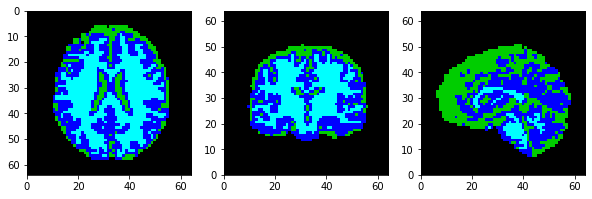

--------------------------------------------------
+ TRAINING 	Epoch: 31 	Loss: 0.796350
+ TRAINING 	Epoch: 32 	Loss: 0.801098
+ TRAINING 	Epoch: 33 	Loss: 0.791773
+ TRAINING 	Epoch: 34 	Loss: 0.798555
+ TRAINING 	Epoch: 35 	Loss: 0.795089
+ TRAINING 	Epoch: 36 	Loss: 0.787295
+ TRAINING 	Epoch: 37 	Loss: 0.790180
+ TRAINING 	Epoch: 38 	Loss: 0.812762
+ TRAINING 	Epoch: 39 	Loss: 0.788569
+ TRAINING 	Epoch: 40 	Loss: 0.792499
--------------------------------------------------
+ VALIDATE 	Epoch: 40 	Loss: 0.794800 	Dice score:0.808954 	F1_score:0.946557


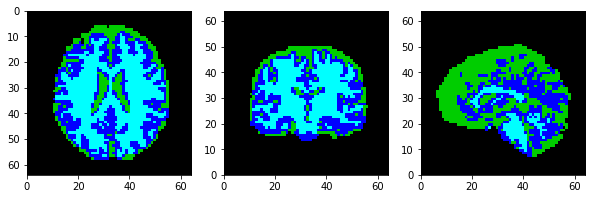

--------------------------------------------------
+ TRAINING 	Epoch: 41 	Loss: 0.788287
+ TRAINING 	Epoch: 42 	Loss: 0.802776
+ TRAINING 	Epoch: 43 	Loss: 0.795851
+ TRAINING 	Epoch: 44 	Loss: 0.797609
+ TRAINING 	Epoch: 45 	Loss: 0.810425
+ TRAINING 	Epoch: 46 	Loss: 0.809123
+ TRAINING 	Epoch: 47 	Loss: 0.787834
+ TRAINING 	Epoch: 48 	Loss: 0.787842
+ TRAINING 	Epoch: 49 	Loss: 0.787376
+ TRAINING 	Epoch: 50 	Loss: 0.804222
--------------------------------------------------
+ VALIDATE 	Epoch: 50 	Loss: 0.791623 	Dice score:0.822476 	F1_score:0.950436


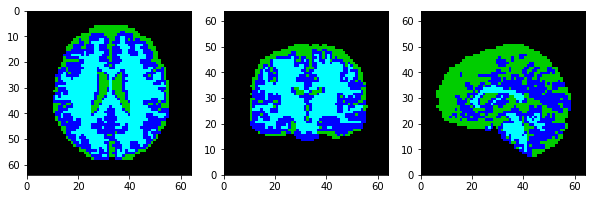

--------------------------------------------------
+ TRAINING 	Epoch: 51 	Loss: 0.806265
+ TRAINING 	Epoch: 52 	Loss: 0.795245
+ TRAINING 	Epoch: 53 	Loss: 0.788714
+ TRAINING 	Epoch: 54 	Loss: 0.801043
+ TRAINING 	Epoch: 55 	Loss: 0.793903
+ TRAINING 	Epoch: 56 	Loss: 0.785242
+ TRAINING 	Epoch: 57 	Loss: 0.785829
+ TRAINING 	Epoch: 58 	Loss: 0.796775
+ TRAINING 	Epoch: 59 	Loss: 0.821419
+ TRAINING 	Epoch: 60 	Loss: 0.790857
--------------------------------------------------
+ VALIDATE 	Epoch: 60 	Loss: 0.789899 	Dice score:0.830438 	F1_score:0.952758


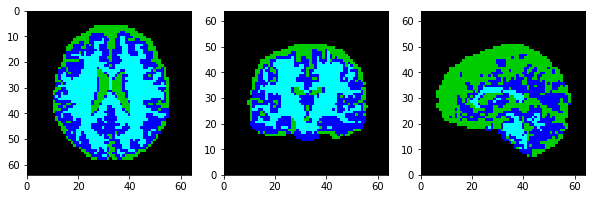

--------------------------------------------------
+ TRAINING 	Epoch: 61 	Loss: 0.793436
+ TRAINING 	Epoch: 62 	Loss: 0.785001
+ TRAINING 	Epoch: 63 	Loss: 0.800152
+ TRAINING 	Epoch: 64 	Loss: 0.781989
+ TRAINING 	Epoch: 65 	Loss: 0.815057
+ TRAINING 	Epoch: 66 	Loss: 0.783931
+ TRAINING 	Epoch: 67 	Loss: 0.795409
+ TRAINING 	Epoch: 68 	Loss: 0.785681
+ TRAINING 	Epoch: 69 	Loss: 0.789842
+ TRAINING 	Epoch: 70 	Loss: 0.785763
--------------------------------------------------
+ VALIDATE 	Epoch: 70 	Loss: 0.790091 	Dice score:0.826137 	F1_score:0.951406


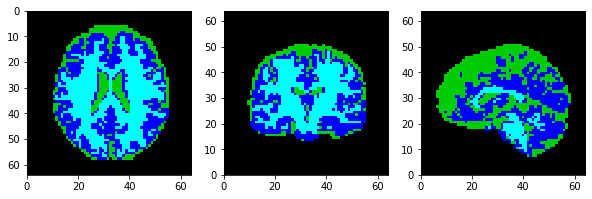

--------------------------------------------------
+ TRAINING 	Epoch: 71 	Loss: 0.791206
+ TRAINING 	Epoch: 72 	Loss: 0.795664
+ TRAINING 	Epoch: 73 	Loss: 0.793473
+ TRAINING 	Epoch: 74 	Loss: 0.783751
+ TRAINING 	Epoch: 75 	Loss: 0.799007
+ TRAINING 	Epoch: 76 	Loss: 0.784987
+ TRAINING 	Epoch: 77 	Loss: 0.792028
+ TRAINING 	Epoch: 78 	Loss: 0.809572
+ TRAINING 	Epoch: 79 	Loss: 0.797984
+ TRAINING 	Epoch: 80 	Loss: 0.783463
--------------------------------------------------
+ VALIDATE 	Epoch: 80 	Loss: 0.787884 	Dice score:0.834603 	F1_score:0.954468


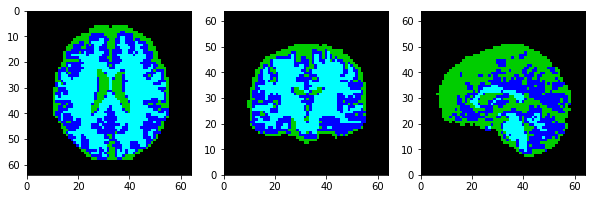

--------------------------------------------------
+ TRAINING 	Epoch: 81 	Loss: 0.795815
+ TRAINING 	Epoch: 82 	Loss: 0.781543
+ TRAINING 	Epoch: 83 	Loss: 0.782475
+ TRAINING 	Epoch: 84 	Loss: 0.785325
+ TRAINING 	Epoch: 85 	Loss: 0.784782
+ TRAINING 	Epoch: 86 	Loss: 0.787654
+ TRAINING 	Epoch: 87 	Loss: 0.786248
+ TRAINING 	Epoch: 88 	Loss: 0.782107
+ TRAINING 	Epoch: 89 	Loss: 0.802937
+ TRAINING 	Epoch: 90 	Loss: 0.793046
--------------------------------------------------
+ VALIDATE 	Epoch: 90 	Loss: 0.787619 	Dice score:0.835917 	F1_score:0.955297


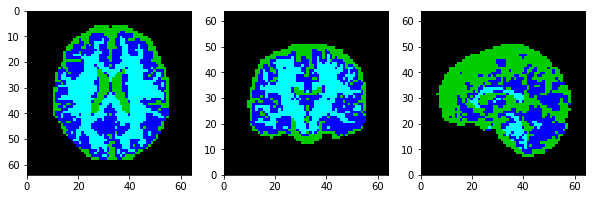

--------------------------------------------------
+ TRAINING 	Epoch: 91 	Loss: 0.784734
+ TRAINING 	Epoch: 92 	Loss: 0.798164
+ TRAINING 	Epoch: 93 	Loss: 0.782530
+ TRAINING 	Epoch: 94 	Loss: 0.783714
+ TRAINING 	Epoch: 95 	Loss: 0.780998
+ TRAINING 	Epoch: 96 	Loss: 0.787553
+ TRAINING 	Epoch: 97 	Loss: 0.789540
+ TRAINING 	Epoch: 98 	Loss: 0.813176
+ TRAINING 	Epoch: 99 	Loss: 0.785298
+ TRAINING 	Epoch: 100 	Loss: 0.799663
--------------------------------------------------
+ VALIDATE 	Epoch: 100 	Loss: 0.788261 	Dice score:0.830006 	F1_score:0.952911


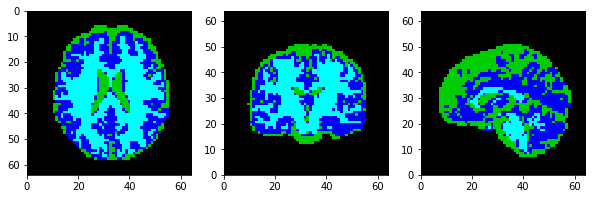

--------------------------------------------------

Finished TRAINING.


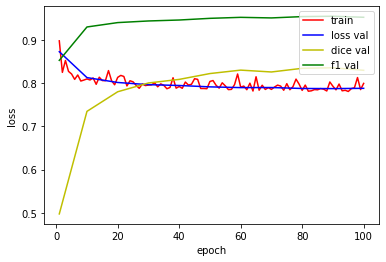

In [ ]:
from sklearn import metrics

model_dir = os.path.join(out_dir, 'model')
if not os.path.exists(model_dir):
    os.makedirs(model_dir)

torch.manual_seed(rnd_seed) #fix random seed

# model = SimpleNet3D(num_classes=num_classes).to(device)
model = SegNet3D(num_classes=num_classes).to(device)
model.train()
    
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

loss_train_log = []
loss_val_log = []
epoch_val_log = []
dice_val_log = []
f1_val_log = []
    
print('START TRAINING...')
for epoch in range(1, num_epochs + 1):

    # Training
    for batch_idx, batch_samples in enumerate(dataloader_train):
        img, seg = batch_samples['img'].to(device), batch_samples['seg'].to(device)
        optimizer.zero_grad()
        prd = model(img)
        prd_flat = prd.view(prd.size(0), prd.size(1), -1)
        seg_flat = seg.view(seg.size(0), seg.size(1), -1)
        loss = F.cross_entropy(prd_flat, seg_flat.squeeze(1))
        loss.backward()
        optimizer.step()

    loss_train_log.append(loss.item())

    print('+ TRAINING \tEpoch: {} \tLoss: {:.6f}'.format(epoch, loss.item()))
    
    # Validation
    if epoch == 1 or epoch % val_interval == 0:
        loss_val = 0
        sum_pts = 0
        idx_val = 0
        dice_score = 0
        f1_measure = 0

        with torch.no_grad():
            for data_sample in dataloader_val:
                img, seg = data_sample['img'].to(device), data_sample['seg'].to(device)
                prd = model(img)
                prd_flat = prd.view(prd.size(0), prd.size(1), -1)
                seg_flat = seg.view(seg.size(0), seg.size(1), -1)
                loss_val += F.cross_entropy(prd_flat, seg_flat.squeeze(1), reduction='sum').item()
                sum_pts += seg_flat.size(2)
                
                sample = dataset_val.get_sample(idx_val)
                prd = torch.argmax(prd, dim=1)

                #Dice score
                prediction = sitk.GetImageFromArray(prd.cpu().squeeze().numpy().astype(np.uint8))
                prediction.CopyInformation(sample['seg'])
                segmentation = sitk.GetImageFromArray(seg.cpu().squeeze().numpy().astype(np.uint8))
                segmentation.CopyInformation(sample['seg'])
                overlap_measures_filter = sitk.LabelOverlapMeasuresImageFilter()
                overlap_measures_filter.Execute(prediction, segmentation)
                dice_score += overlap_measures_filter.GetDiceCoefficient()
                
                #F1_score: F1 = 2 * (precision * recall) / (precision + recall)
                prd_d = prd.view(prd.size()[0],-1)
                seg_d = seg.view(seg.size()[0],-1)
                f1_measure += metrics.f1_score(seg_d.cpu().squeeze(),prd_d.cpu().squeeze(),average='weighted')
                
                idx_val += 1

        # prd = torch.argmax(prd, dim=1)
        prediction = sitk.GetImageFromArray(prd.cpu().squeeze().numpy().astype(np.uint8))
        
        loss_val /= sum_pts
        avg_dice_score = dice_score / idx_val
        avg_f1_measure = f1_measure.item() / idx_val

        loss_val_log.append(loss_val)
        epoch_val_log.append(epoch)
        dice_val_log.append(avg_dice_score)
        f1_val_log.append(avg_f1_measure)

        print('--------------------------------------------------')
        print('+ VALIDATE \tEpoch: {} \tLoss: {:.6f} \tDice score:{:6f} \tF1_score:{:6f}'.format
              (epoch, loss_val,avg_dice_score,avg_f1_measure))
        display_image(sitk.LabelToRGB(prediction))
        print('--------------------------------------------------')

torch.save(model.state_dict(), os.path.join(model_dir, 'model.pt'))

print('\nFinished TRAINING.')


plt.plot(range(1, num_epochs + 1), loss_train_log, c='r', label='train')
plt.plot(epoch_val_log, loss_val_log, c='b', label='loss val')
plt.plot(epoch_val_log, dice_val_log, c='y', label='dice val')
plt.plot(epoch_val_log, f1_val_log, c='g', label='f1 val')
plt.legend(loc='upper right')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

#### Loading and pre-processing of testing data

Now that we have trained a model, we apply that model to the 500 subjects that are used for training the age regressor. 

In [ ]:
meta_data_reg_train = pd.read_csv(data_dir + 'meta/meta_data_reg_train.csv')
meta_data_reg_test = pd.read_csv(data_dir + 'meta/meta_data_reg_test.csv')

ids_seg_test = list(meta_data_reg_test['subject_id'])
files_seg_img_test = [data_dir + 'images/sub-' + f + '_T1w_unbiased.nii.gz' for f in ids_seg_test]
files_seg_seg_test = [data_dir + 'segs_refs/sub-' + f + '_T1w_seg.nii.gz' for f in ids_seg_test]
files_seg_msk_test = [data_dir + 'masks/sub-' + f + '_T1w_brain_mask.nii.gz' for f in ids_seg_test]

dataset_test = ImageSegmentationDataset(files_seg_img_test, files_seg_seg_test, files_seg_msk_test, img_spacing, img_size)
dataloader_test = torch.utils.data.DataLoader(dataset_test, batch_size=1, shuffle=False)

Loading Data: 100%|██████████| 100/100 [00:18<00:00,  5.12it/s]


#### Visualise testing example

Just to check how a testing image looks like after pre-processing.

Image: sub-CC321594_T1w_unbiased.nii.gz


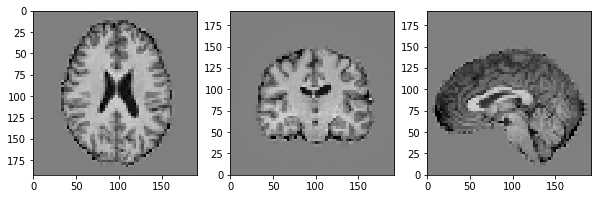

Segmentation


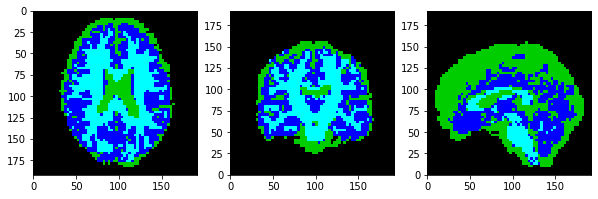

Mask


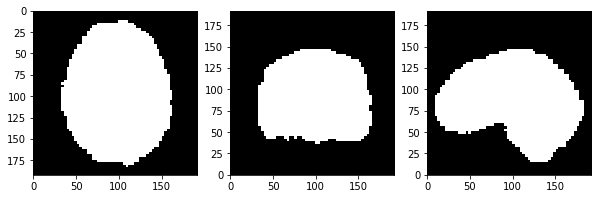

In [ ]:
sample = dataset_test.get_sample(0)
img_name = dataset_test.get_img_name(0)
seg_name = dataset_test.get_seg_name(0)
print('Image: ' + img_name)
display_image(sample['img'], window=5, level=0)
print('Segmentation')
display_image(sitk.LabelToRGB(sample['seg']))
print('Mask')
display_image(sample['msk'])

#### TESTING

Implementation of a full testing procedure that saves the segmentations in an output folder. 

START TESTING...
+ TESTING 	Loss: 0.792147, 	Average Dice Score:0.814266, 	Average F1_measure:0.948666


Reference segmentation


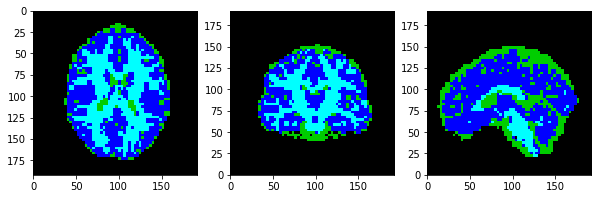

Predicted segmentation


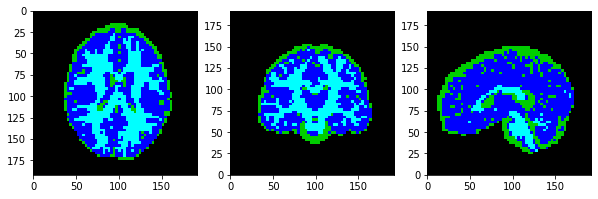


Finished TESTING.


In [ ]:
from sklearn import metrics

pred_dir = os.path.join(out_dir, 'pred')
if not os.path.exists(pred_dir):
    os.makedirs(pred_dir)

# model = SimpleNet3D(num_classes=num_classes)
model = SegNet3D(num_classes=num_classes)
model.load_state_dict(torch.load(os.path.join(model_dir, 'model.pt')))
model.to(device)
model.eval()
    
print('START TESTING...')

loss_test = 0
sum_pts = 0
idx_test = 0
dice_score = 0
f1_measure = 0
with torch.no_grad():
    for data_sample in dataloader_test:
        img, seg = data_sample['img'].to(device), data_sample['seg'].to(device)
        prd = model(img)
        prd_flat = prd.view(prd.size(0), prd.size(1), -1)
        seg_flat = seg.view(seg.size(0), seg.size(1), -1)
        loss_test += F.cross_entropy(prd_flat, seg_flat.squeeze(1), reduction='sum').item()
        sum_pts += seg_flat.size(2)        
        
        prd = torch.argmax(prd, dim=1)

        #F1_score: F1 = 2 * (precision * recall) / (precision + recall)
        prd_d = prd.view(prd.size()[0],-1)
        seg_d = seg.view(seg.size()[0],-1)
        f1_measure += metrics.f1_score(seg_d.cpu().squeeze(),prd_d.cpu().squeeze(),average='weighted')


        sample = dataset_test.get_sample(idx_test)
        name = dataset_test.get_seg_name(idx_test)
        prediction = sitk.GetImageFromArray(prd.cpu().squeeze().numpy().astype(np.uint8))
        prediction.CopyInformation(sample['seg'])
        sitk.WriteImage(prediction, os.path.join(pred_dir, name))

        #Dice score
        segmentation = sitk.GetImageFromArray(seg.cpu().squeeze().numpy().astype(np.uint8))
        segmentation.CopyInformation(sample['seg'])
        overlap_measures_filter = sitk.LabelOverlapMeasuresImageFilter()
        overlap_measures_filter.Execute(prediction,segmentation)
        dice_score += overlap_measures_filter.GetDiceCoefficient()

        idx_test += 1
        
loss_test /= sum_pts
avg_dice_score = dice_score / idx_test
avg_f1_measure = f1_measure.item() / idx_test

print('+ TESTING \tLoss: {:.6f}, \tAverage Dice Score:{:6f}, \tAverage F1_measure:{:6f}'.format
      (loss_test, avg_dice_score,avg_f1_measure))

# Show last testing sample as an example
print('\n\nReference segmentation')
display_image(sitk.LabelToRGB(sample['seg']))
print('Predicted segmentation')
display_image(sitk.LabelToRGB(prediction))

print('\nFinished TESTING.')

### TASK A-2: Feature calculation

Calculated the three absolute tissue volumes for each subject. Plotted the volumes against the subjects' ages. Taking the absolute volumes of tissues as features, however, might not be predictive. Instead, relative volumes are computed as the ratios between each tissue volume and overall brain volume. We can also explore using different combinations or even polynomial features.


In [ ]:
## CALCULATE ABSOLUTE TISSUE VOLUMES

import os
import collections

# USE THIS TO RUN THE CALCULATIONS ON YOUR SEGMENTATONS
seg_dir = './output/pred/'

# USE THIS TO RUN THE CALCULATIONS ON REFERENCE SEGMENTATIONS
# seg_dir = data_dir + 'segs_refs/'

meta_data_reg_train = pd.read_csv(data_dir + 'meta/meta_data_reg_train.csv')
ids_reg_train = list(meta_data_reg_train['subject_id'])
files_reg_seg_train = [seg_dir + 'sub-' + f + '_T1w_seg.nii.gz' for f in ids_reg_train]


meta_data_reg_test = pd.read_csv(data_dir + 'meta/meta_data_reg_test.csv')
ids_reg_test = list(meta_data_reg_test['subject_id'])
files_reg_seg_test = [seg_dir + 'sub-' + f + '_T1w_seg.nii.gz' for f in ids_reg_test]

# THIS MATRIX WILL STORE THE VOLUMES PER TISSUE CLASS
vols = np.zeros((3,len(files_reg_seg_train)))

vols_our = np.zeros((3,len(files_reg_seg_test)))

vols_test = np.zeros((3,len(files_reg_seg_test)))

for idx, _ in enumerate(tqdm(range(len(files_reg_seg_train)), desc='Calculating Features')):
    
    seg_filename = files_reg_seg_train[idx]
    
    if os.path.exists(seg_filename):
        seg = sitk.ReadImage(seg_filename)

        seg = resample_image(seg,img_spacing,img_size,is_label=True)
        seg_array = sitk.GetArrayFromImage(seg)
        seg_transformed = seg_array.flatten().squeeze()
        freq = collections.Counter(seg_transformed)

        x,y,z = seg.GetSpacing()
        vols[:,idx] = freq[1]*x*y*z, freq[2]*x*y*z, freq[3]*x*y*z

for idx, _ in enumerate(tqdm(range(len(files_reg_seg_test)), desc='Calculating Features')):
    
    seg_filename = files_reg_seg_test[idx]
    if os.path.exists(seg_filename):
        
        seg = sitk.ReadImage(seg_filename)
        
        seg = resample_image(seg,img_spacing,img_size,is_label=True)
        seg_array = sitk.GetArrayFromImage(seg)
        seg_transformed = seg_array.flatten().squeeze()
        freq = collections.Counter(seg_transformed)

        x,y,z = seg.GetSpacing()
        vols_our[:,idx] = freq[1]*x*y*z, freq[2]*x*y*z, freq[3]*x*y*z

for idx, _ in enumerate(tqdm(range(len(files_reg_seg_test)), desc='Calculating Features')):
    
    seg_filename = files_reg_seg_test[idx]
    
    if os.path.exists(seg_filename):
        seg = sitk.ReadImage(seg_filename)

        seg = resample_image(seg,img_spacing,img_size,is_label=True)
        seg_array = sitk.GetArrayFromImage(seg)
        seg_transformed = seg_array.flatten().squeeze()
        freq = collections.Counter(seg_transformed)

        x,y,z = seg.GetSpacing()
        vols_test[:,idx] = freq[1]*x*y*z, freq[2]*x*y*z, freq[3]*x*y*z


Calculating Features: 100%|██████████| 100/100 [00:05<00:00, 19.47it/s]


Plot features versus age.

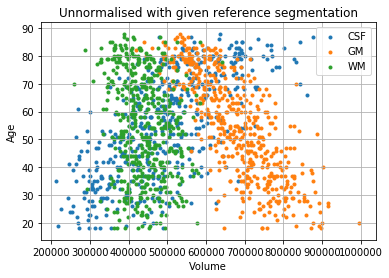

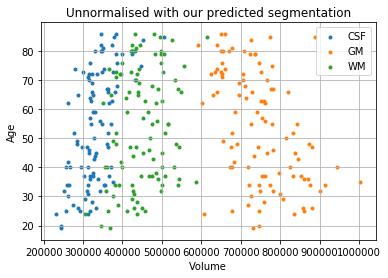

In [ ]:
plt.scatter(vols[0,:],meta_data_reg_train['age'], marker='.')
plt.scatter(vols[1,:],meta_data_reg_train['age'], marker='.')
plt.scatter(vols[2,:],meta_data_reg_train['age'], marker='.')
plt.grid()
plt.title('Unnormalised with given reference segmentation')
plt.xlabel('Volume')
plt.ylabel('Age')
plt.legend(('CSF','GM','WM'))
plt.show()

plt.scatter(vols_our[0,:],meta_data_reg_test['age'], marker='.')
plt.scatter(vols_our[1,:],meta_data_reg_test['age'], marker='.')
plt.scatter(vols_our[2,:],meta_data_reg_test['age'], marker='.')
plt.grid()
plt.title('Unnormalised with our predicted segmentation')
plt.xlabel('Volume')
plt.ylabel('Age')
plt.legend(('CSF','GM','WM'))
plt.show()

In [ ]:
## CALCULATE RELATIVE TISSUE VOLUMES

vols_normalised = np.zeros((3,len(files_reg_seg_train)))

vols_normalised = vols / (vols[0, :] + vols[1, :] + vols[2, :])
vols_our_normalised = vols_our / (vols_our[0, :] + vols_our[1, :] + vols_our[2, :])
vols_test_normalised = vols_test / (vols_test[0, :] + vols_test[1, :] + vols_test[2, :])

Plot normalised features versus age.

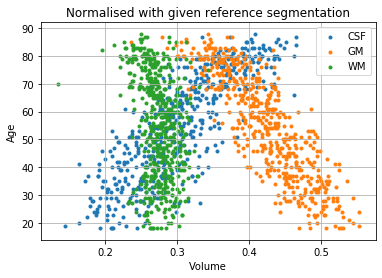

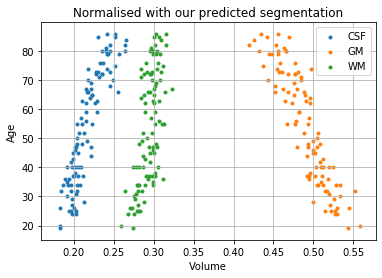

In [ ]:
plt.scatter(vols_normalised[0,:],meta_data_reg_train['age'], marker='.')
plt.scatter(vols_normalised[1,:],meta_data_reg_train['age'], marker='.')
plt.scatter(vols_normalised[2,:],meta_data_reg_train['age'], marker='.')
plt.grid()
plt.title('Normalised with given reference segmentation')
plt.xlabel('Volume')
plt.ylabel('Age')
plt.legend(('CSF','GM','WM'))
plt.show()

plt.scatter(vols_our_normalised[0,:],meta_data_reg_test['age'], marker='.')
plt.scatter(vols_our_normalised[1,:],meta_data_reg_test['age'], marker='.')
plt.scatter(vols_our_normalised[2,:],meta_data_reg_test['age'], marker='.')
plt.grid()
plt.title('Normalised with our predicted segmentation')
plt.xlabel('Volume')
plt.ylabel('Age')
plt.legend(('CSF','GM','WM'))
plt.show()

Final data for age regression

In [ ]:
X = vols_normalised.T
y = meta_data_reg_train['age'].values.reshape(-1,1)

X_test_set = vols_test_normalised.T
y_test_set = meta_data_reg_test['age'].values.reshape(-1,1)

print(X.shape)
print(y.shape)

(500, 3)
(500, 1)


### TASK A-3: Age regression and cross-validation

Experimented with different regression methods from the [scikit-learn toolkit](http://scikit-learn.org/stable/supervised_learning.html#supervised-learning). 

Evaluated the methods using two-fold [cross-validation](http://scikit-learn.org/stable/modules/cross_validation.html#cross-validation) where the dataset of 500 subjects is split into two equally sized sets $(X_1,y_1)$ and $(X_2,y_2)$ which are used for training and testing in an alternating way (so each set is used as $(X_{\text{train}},y_{\text{train}})$ and $(X_{\text{test}},y_{\text{test}})$ exactly once).

In [ ]:
def display_performance(y,predicted,title=None):
    print('mean absolute error: {0}'.format(mean_absolute_error(y,predicted)))
    print('r2 score: {0}'.format(r2_score(y,predicted)))
  
    fig, ax = plt.subplots()
    ax.scatter(y, predicted, marker='.')
    ax.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=2)
    ax.set_xlabel('Real Age')
    ax.set_ylabel('Predicted Age')y

    plt.title(title)
    plt.show()

mean absolute error: 8.048
r2 score: 0.6954590518609682


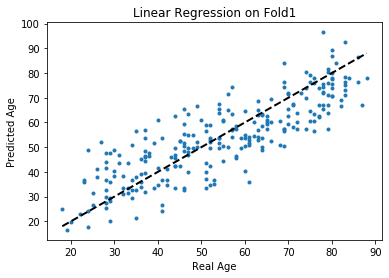

mean absolute error: 8.03571128403361
r2 score: 0.6965775943054943


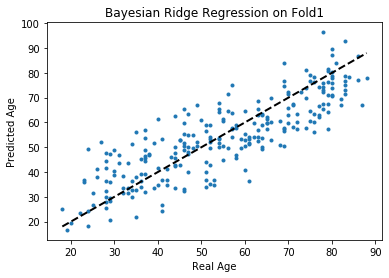

mean absolute error: 7.952
r2 score: 0.6957154508470934


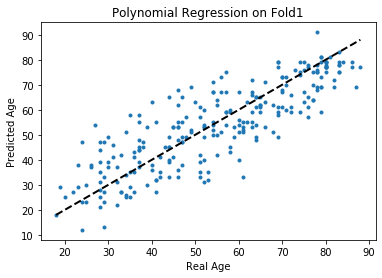

mean absolute error: 7.6418125
r2 score: 0.7413605301491941


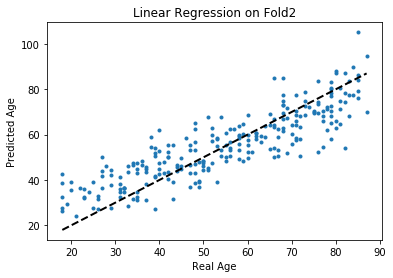

mean absolute error: 7.6483438677966475
r2 score: 0.7412600583042321


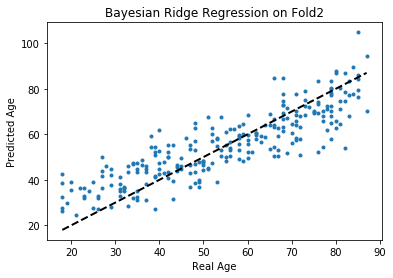

mean absolute error: 7.595
r2 score: 0.6789489559122158


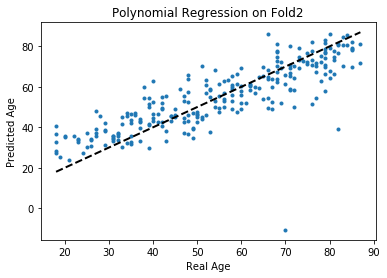

In [ ]:
from sklearn.model_selection import KFold
from sklearn import linear_model
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.linear_model import BayesianRidge

y = y.squeeze()

kf = KFold(n_splits=2, random_state=rnd_seed,shuffle=True)
count = 1


for train,test in kf.split(X):
    X_train, X_test = X[train], X[test]
    y_train, y_test = y[train],y[test]
    # print('X_train:',X_train.shape)
    # print('y_test:',y_test.shape)

    #linear regression
    linear = linear_model.LinearRegression(normalize=True)
    linear.fit(X_train,y_train)
    linear_pred = linear.predict(X_test)

    #bayesian regression
    bayesian = BayesianRidge(normalize=True)
    bayesian.fit(X_train,y_train)
    bayesian_pred = bayesian.predict(X_test)

    #polynomial regression
    polynomial = PolynomialFeatures(degree=3)
    X_train_poly = polynomial.fit_transform(X_train)
    X_test_poly = polynomial.fit_transform(X_test)
    poly_linear = linear_model.LinearRegression(normalize=True)
    poly_linear.fit(X_train_poly,y_train)
    poly_pred = poly_linear.predict(X_test_poly)

    display_performance(y_test,linear_pred,title='Linear Regression on Fold'+ str(count))
    display_performance(y_test,bayesian_pred,title='Bayesian Ridge Regression on Fold'+ str(count))
    display_performance(y_test,poly_pred,title='Polynomial Regression on Fold'+ str(count))

    count += 1



According to the average performance, Bayesian is the best regressor in terms of the r2 score, while Polynomial regression performs best under the MAE. Presented here is the polynomial regressor applied to the test set.

Error calculation and plotting

mean absolute error: 6.69625
r2 score: 0.7982026134068695


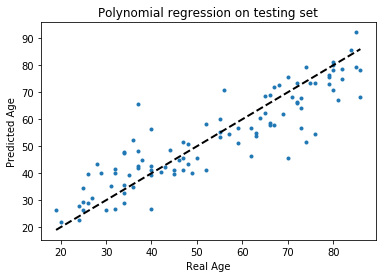

In [ ]:
# Polynomial Regression
polynomial = PolynomialFeatures(degree=3)
X_poly = polynomial.fit_transform(X)
X_test_poly = polynomial.fit_transform(X_test_set)
poly_linear = linear_model.LinearRegression(normalize=True)
poly_linear.fit(X_poly,y)
poly_pred = poly_linear.predict(X_test_poly)

title = "Polynomial regression on testing set"
display_performance(y_test_set, poly_pred, title)

## Part B: PCA-based regression using grey matter maps

The second approach will make use of grey matter maps that have been already extracted from the MRI scans and aligned to a common reference space to obtain spatially normalised maps, using an advanced, state-of-the-art neuroimaging toolkit, called SPM12. 

Because these grey matter maps are spatially normalised (ie., registered), voxel locations across images from different subjects roughly correspond to the same anatomical locations. This means that each voxel location in the grey matter maps can be treated as an individual feature. Because those maps are quite large at their full resolution there would be a very large number of features to deal with (more than 850,000). We use Principal Component Analysis (PCA) to perform dimensionality reduction before training a suitable regressor on the low-dimensional feature representation. The implemented pipeline is evaluated using two-fold cross-validation using the same data splits as in part A for the 500 subjects, so the two different approaches can be directly compared in terms of average age prediction accuracy.


### TASK B-1: Pre-processing

Before running PCA to reduce the dimensionality of the feature space for grey matter maps, in voxel-based analysis where each voxel location is a feature, it is common to apply some smoothing beforehand. This is to reduce noise and to compensate for errors of the spatial normalisation. Because the maps are quite large, it is worthwile to downsample first. 

File CC520745 saved


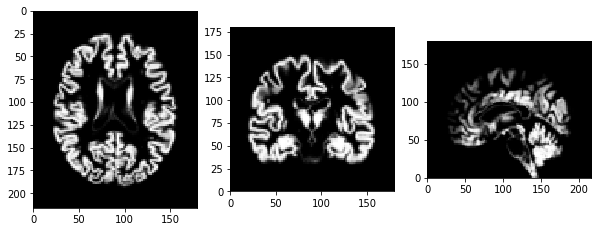

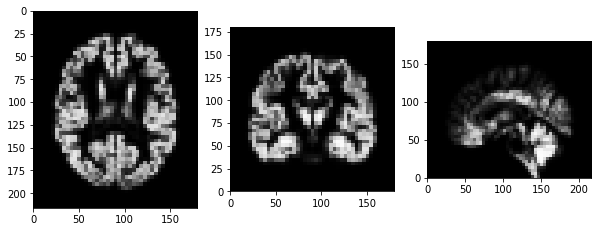

File CC520239 saved
File CC620592 saved
File CC310391 saved
File CC621011 saved
File CC620499 saved
File CC320698 saved
File CC521040 saved
File CC620259 saved
File CC420162 saved
File CC420094 saved
File CC320088 saved
File CC510015 saved
File CC510304 saved
File CC310407 saved
File CC620885 saved
File CC420454 saved
File CC420143 saved
File CC220335 saved
File CC610212 saved
File CC720941 saved
File CC420623 saved
File CC620610 saved
File CC620429 saved
File CC610288 saved
File CC620354 saved
File CC310450 saved
File CC221733 saved
File CC121111 saved
File CC320379 saved
File CC420260 saved
File CC420137 saved
File CC320342 saved
File CC620720 saved
File CC420198 saved
File CC321529 saved
File CC210526 saved
File CC720103 saved
File CC110101 saved
File CC120008 saved
File CC520122 saved
File CC721504 saved
File CC412004 saved
File CC610061 saved
File CC710486 saved
File CC112141 saved
File CC510355 saved
File CC320608 saved
File CC210250 saved
File CC221775 saved
File CC221487 saved


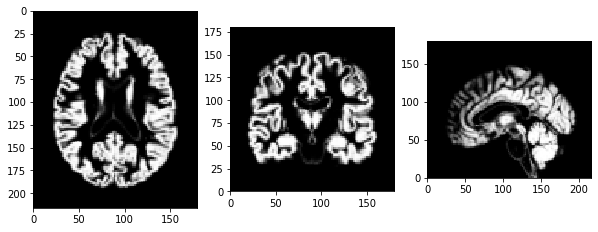

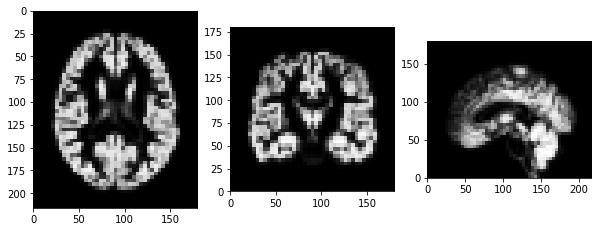

File CC120640 saved
File CC722542 saved
File CC610227 saved
File CC310463 saved
File CC222120 saved
File CC520868 saved
File CC410173 saved
File CC620193 saved
File CC210023 saved
File CC410387 saved
File CC320202 saved
File CC410220 saved
File CC310414 saved
File CC610372 saved
File CC520254 saved
File CC120123 saved
File CC520083 saved
File CC621248 saved
File CC520517 saved
File CC520247 saved
File CC220999 saved
File CC510629 saved
File CC220697 saved
File CC520398 saved
File CC210422 saved
File CC320574 saved
File CC110069 saved
File CC510438 saved
File CC620490 saved
File CC121194 saved
File CC410040 saved
File CC221755 saved
File CC222496 saved
File CC420100 saved
File CC222555 saved
File CC210617 saved
File CC710214 saved
File CC520503 saved
File CC722216 saved
File CC510115 saved
File CC710664 saved
File CC610405 saved
File CC710099 saved
File CC520211 saved
File CC721585 saved
File CC321087 saved
File CC120065 saved
File CC121144 saved
File CC610576 saved
File CC120795 saved


In [ ]:
# Create the directory if not exist
if not os.path.exists(data_dir + 'processed_greymatter'):
  os.makedirs(data_dir + 'processed_greymatter')

def preprocess_data(data_id, display=False, down_factor=2):
  data_list = []
  first_flag = 1
  for i in range(data_id.count()):
    # Get the file name through img id
    img_id = data_id[i]
    file_name = data_dir + 'processed_greymatter/' + img_id + '.nii.gz'
    img = None

    # For debugging
    read = False

    # Read the processed images instead of computing them again
    if os.path.exists(file_name) and read == True:
      img = sitk.ReadImage(file_name)
      img_size = img.GetSize()
      print("File " + img_id + " read")

    # Preprocess the image and save it
    else:
      img_data_filename = data_dir + 'greymatter/wc1sub-' + img_id + '_T1w.nii.gz'
      img_data_raw = sitk.Cast(sitk.ReadImage(img_data_filename), sitk.sitkFloat32)

      # Perform Anisotropic Diffussion
      img = sitk.GradientAnisotropicDiffusion(img_data_raw)

      # Perform Downsampling
      img = img[::down_factor, ::down_factor, ::down_factor]

      # Store the processed image
      sitk.WriteImage(img, file_name)
      print("File " + img_id + " saved")  

    # Store the image into the list
    img_arr = sitk.GetArrayFromImage(img)
    img_processed = img_arr.flatten().squeeze()
    data_list.append(img_processed)

    if first_flag == 1:
      # Visualise samples before and after pre-processing
      # Before pre-processing
      img_data_filename = data_dir + 'greymatter/wc1sub-' + img_id + '_T1w.nii.gz'
      img_data_raw = sitk.ReadImage(img_data_filename)
      display_image(img_data_raw)
      # After pre-processing
      display_image(img)
    first_flag = 0
  return data_list

# Preprocess training data and test data
X_train = preprocess_data(meta_data_reg_train['subject_id'], True)
X_test = preprocess_data(meta_data_reg_test['subject_id'])

In [ ]:
# check the shape
X = np.array(X_train)
y = meta_data_reg_train['age'].values.reshape(-1,1)

print(img_size)
print(X.shape)
print(y.shape)

[64, 64, 64]
(500, 109350)
(500, 1)


### TASK B-2: Dimensionality reduction

Implemented dimensionality reduction for grey matter maps using [scitkit-learn's PCA](http://scikit-learn.org/stable/modules/decomposition.html#pca). Initially preserved 95% of the variance (`n_components=0.95`).

When dimensionality reduction is used as pre-processing step for supervised learning, as in this case, it is important that PCA is fitted to the training data only, but then applied to both the training and testing data. This implementation consists of two separate steps, 1) fitting the PCA model to $X_{\text{train}}$ (using the `fit` function), and 2) applying dimensionality reduction to $X_{\text{train}}$ and $X_{\text{test}}$ using the `transform` function.

In [ ]:
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split

# Load the data
X_tr = np.array(X_train)
y_tr = meta_data_reg_train['age'].values.reshape(-1,1)
X_te = np.array(X_test)
y_te = meta_data_reg_test['age'].values.reshape(-1,1)
print(X_te.shape)
# Perform PCA
pca = PCA(n_components = 0.95)
pca.fit(X_tr)
X_tr_pca = pca.transform(X_tr)
X_te_pca = pca.transform(X_te)
print(X_tr_pca.shape)

(100, 109350)
(500, 440)


### TASK B-3: Age regression and cross-validation

Experimented with different regression methods from the [scikit-learn toolkit](http://scikit-learn.org/stable/supervised_learning.html#supervised-learning). Evaluated the methods using two-fold [cross-validation](http://scikit-learn.org/stable/modules/cross_validation.html#cross-validation) in the same way as in Part A so results can be directly compared.


mean absolute error: 5.5697243194580075
r2 score: 0.860768633094217


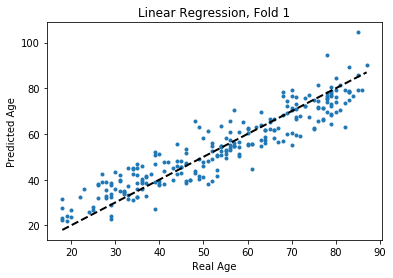

/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


mean absolute error: 8.096489374455208
r2 score: 0.7211178492304482


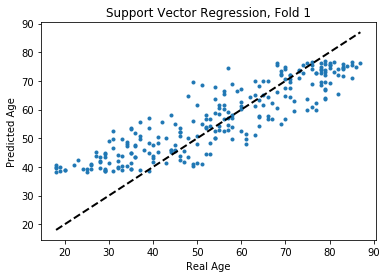

/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


mean absolute error: 5.7633615658292
r2 score: 0.8547711673100933


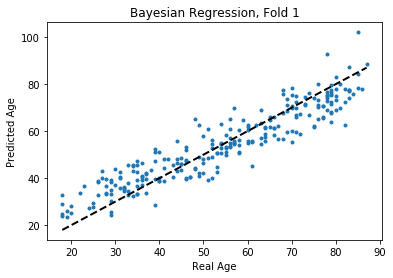

mean absolute error: 5.480970985412598
r2 score: 0.8608490945662552


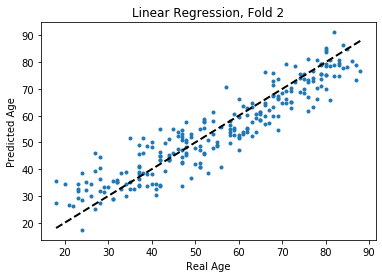

/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


mean absolute error: 7.703482956004505
r2 score: 0.7290432233564796


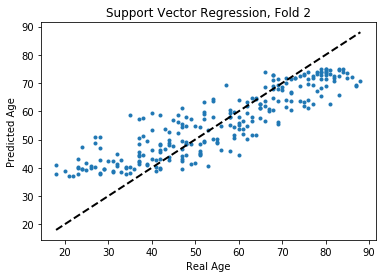

/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


mean absolute error: 5.688494399767413
r2 score: 0.8529863273385518


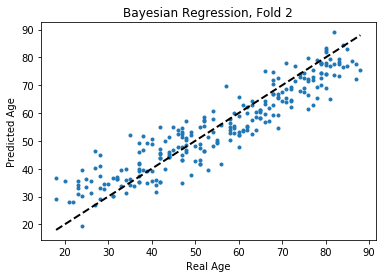

In [ ]:
from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn import linear_model
from sklearn.preprocessing import PolynomialFeatures
from sklearn import svm

def display_result(y, predicted, title):
  print('mean absolute error: {0}'.format(mean_absolute_error(y,predicted)))
  print('r2 score: {0}'.format(r2_score(y,predicted)))

  fig, ax = plt.subplots()
  ax.scatter(y, predicted, marker='.')
  ax.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=2)
  ax.set_xlabel('Real Age')
  ax.set_ylabel('Predicted Age')
  plt.title(title)
  plt.show()

count = 1
y_tr = y_tr.squeeze()

# 2-fold cross validation
kf = KFold(n_splits=2, shuffle=False)
for train_index, test_index in kf.split(X_tr):
  X_train, X_test = X[train_index], X[test_index]
  y_train, y_test = y[train_index], y[test_index]

  # PCA on train and test set
  pca = PCA(n_components = 0.95)
  pca.fit(X_train)
  X_train_pca = pca.transform(X_train)
  X_test_pca = pca.transform(X_test)

  # Linear Regression
  linear = linear_model.LinearRegression(normalize=True)
  linear.fit(X_train_pca,y_train)
  linear_pred = linear.predict(X_test_pca)
  title = "Linear Regression, Fold "+ str(count)
  display_result(y_test, linear_pred, title)


  # Support Vector Regression
  svr_reg = svm.SVR()
  svr_reg.fit(X_train_pca, y_train)
  svr_pred = svr_reg.predict(X_test_pca)
  title = "Support Vector Regression, Fold "+ str(count)
  display_result(y_test, svr_pred, title)

  # Bayesian Regression
  bayes_reg = linear_model.BayesianRidge(normalize=True)
  bayes_reg.fit(X_train_pca, y_train)
  bayes_pred = bayes_reg.predict(X_test_pca)
  title = "Bayesian Regression, Fold "+ str(count)
  display_result(y_test, bayes_pred, title)
  
  count += 1

From the above, we can see that Linear regressor perform the best in the cross-validation. So we will implement Linear regressor for the final testing.






mean absolute error: 5.491595068712994
r2 score: 0.8864352486584276


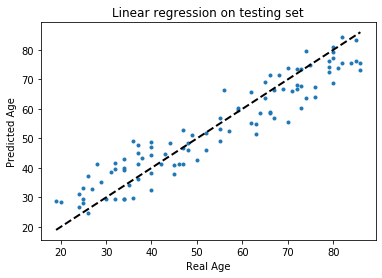

In [ ]:
# Test
linear_reg = linear_model.LinearRegression()
linear_reg.fit(X_tr_pca, y_tr)
linear_pred = linear_reg.predict(X_te_pca)
title = "Linear regression on testing set"
display_result(y_te, linear_pred, title)

## Part C: CNN-based regression using grey matter maps

The third approach is similar in nature to the second approach in task B, but instead of using PCA for dimensionality reduction in order to use a more classical regression model, a convolutional neural networks (CNNs) is used on the grey matter maps for predicting the subject's age directly.

Implemented a CNN model that takes a grey matter map as an input and maps it to a one-dimensional, real-valued output. Started with a LeNet-type architecture and adapted the last layers to convert the classification into a regression network. 


In [ ]:
# Hyperparameters
rnd_seed = 0 #fixed random seed

img_size = [64, 64, 64]
img_spacing = [3, 3, 3]

num_epochs = 60
learning_rate = 0.0005
batch_size = 2
val_interval = 10
leaky_slope = 0.2

out_dir = './output'

# Create output directory
if not os.path.exists(out_dir):
    os.makedirs(out_dir)

In [ ]:
# Data Resampling
def resample_image(image, out_spacing=(3.0,3.0,3.0), out_size=None, is_label=False, pad_value=0):
    """Resamples an image to given element spacing and output size."""

    original_size = np.array(image.GetSize())
    original_spacing = np.array(image.GetSpacing())

    if out_size is None:
        out_size = np.round(np.array(original_size * original_spacing / np.array(out_spacing))).astype(int)
    else:
        out_size = np.array(out_size)

    original_direction = np.array(image.GetDirection()).reshape(len(original_spacing),-1)
    original_center = (np.array(original_size, dtype=float) - 1.0) / 2.0 * original_spacing
    out_center = (np.array(out_size, dtype=float) - 1.0) / 2.0 * np.array(out_spacing)

    original_center = np.matmul(original_direction, original_center)
    out_center = np.matmul(original_direction, out_center)
    out_origin = np.array(image.GetOrigin()) + (original_center - out_center)

    # Apply smoothing to grey matter maps
    image_smooth = image
    for d in range(3):
        factor = out_spacing[d] / original_spacing[d]
        sigma = 0.5 * factor
        image_smooth = sitk.RecursiveGaussian(image_smooth, sigma=sigma, direction=d)

    resample = sitk.ResampleImageFilter()
    resample.SetOutputSpacing(out_spacing)
    resample.SetSize(out_size.tolist())
    resample.SetOutputDirection(image.GetDirection())
    resample.SetOutputOrigin(out_origin.tolist())
    resample.SetTransform(sitk.Transform())
    resample.SetDefaultPixelValue(pad_value)

    if is_label:
        resample.SetInterpolator(sitk.sitkNearestNeighbor)
    else:
        resample.SetInterpolator(sitk.sitkBSpline)

    return resample.Execute(image_smooth)

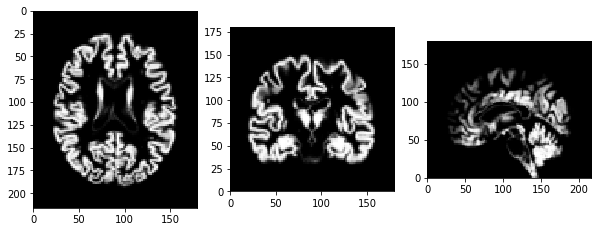

Loading Data: 100%|██████████| 500/500 [00:07<00:00, 62.85it/s]


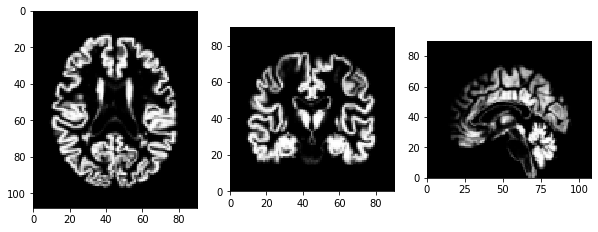

In [ ]:
# Loading and Visualisaing Grey Matter Map Data (Before and After pre-processing)
from torch.utils.data import sampler
from torch.utils.data.sampler import SubsetRandomSampler

# Set Random Seed
np.random.seed(rnd_seed)

meta_data_reg_train = pd.read_csv(data_dir + 'meta/meta_data_reg_train.csv')
ids_gm_train = list(meta_data_reg_train['subject_id'])
files_gm_train = [data_dir + 'greymatter/wc1sub-' + f + '_T1w.nii.gz' for f in ids_gm_train]

gm = sitk.ReadImage(str(files_gm_train[0]))
display_image(gm)

# Get Datasets
def ConvRegressionDataset(file_list_gm, img_spacing, img_size):
    gm_samples = torch.FloatTensor(len(file_list_gm), 1, 90, 108, 90)
    for idx, _ in enumerate(tqdm(range(len(file_list_gm)), desc='Loading Data')):
        gm_path = file_list_gm[idx]
        gm = sitk.ReadImage(gm_path, sitk.sitkFloat32)
        #gm = resample(gm) # Currently works better without pre-processing
        gm_samples[idx,:,:,:,:] = torch.from_numpy(sitk.GetArrayFromImage(gm)).unsqueeze(0).unsqueeze(0)

    return gm_samples

dataset_train = ConvRegressionDataset(files_gm_train, img_spacing, img_size=None)
age_train = meta_data_reg_train['age'].values.reshape(-1,1)

# Shuffle
indices = list(range(len(dataset_train)))
split_num = int(np.floor(0.5 * len(dataset_train)))
np.random.shuffle(indices)
fold1_idx, fold2_idx = indices[:split_num], indices[split_num:]

# Create dataloaders for 2-fold cross validation
fold1_dataloader = torch.utils.data.DataLoader(dataset_train[fold1_idx], batch_size=1, shuffle = False)
fold2_dataloader = torch.utils.data.DataLoader(dataset_train[fold2_idx], batch_size=1, shuffle = False)
cv_dataloader = [fold1_dataloader, fold2_dataloader]

# y value for two folders
fold1_y = age_train[fold1_idx]
fold2_y = age_train[fold2_idx]
fold1_y = torch.FloatTensor(fold1_y).unsqueeze(0).unsqueeze(0).to(device)
fold2_y = torch.FloatTensor(fold2_y).unsqueeze(0).unsqueeze(0).to(device)
cv_y = [fold1_y, fold2_y]


# Display a sample image
for sample_images in fold1_dataloader:
    sample_image = sample_images[0]
display_image(sitk.GetImageFromArray(sample_image.squeeze(0)))

In [ ]:
# Output size calculator helper function
def output_size(input_size, k, s):
    output_size = [0,0,0] #D, H, W
    for i in range(len(input_size)):
        output_size[i] = np.floor((input_size[i] - k[i]) / s) + 1 # stride = 1, padding = 0, dilation = 1
    return output_size

In [ ]:
# Calculate output shape for transition between convolutional and linear layers
input_size = list(sample_image.size()[-3:])
# Trying different kernels and strided convolutions:
#kernels = [(3,3,3), (3,3,1), (3,3,1), (3,3,1), (3,3,1), (3,3,1), (3,3,1), (3,3,1)]
#kernels = [(3,3,3), (3,3,3), (3,3,3), (3,3,3), (3,3,3), (3,3,3), (3,3,3), (3,3,3)]
#s = [1,1,1,1,2,2,2,2]
#kernels = [(3,3,1), (3,3,1), (3,3,1)]#, (3,3,1)]
kernels = [(3,3,1), (2,2,2), (3,3,1), (2,2,2)]
s = [2,2,2,2]

output_s = [0,0,0]

for i in range(len(kernels)):
    output_s = output_size(input_size, list(kernels[i]), s[i])
    input_size = output_s

print(output_s)

[5.0, 6.0, 5.0]


In [ ]:
########################################
class LeNetRegressor(nn.Module):
    def __init__(self):
        super(LeNetRegressor, self).__init__()
        # 3D Convolutional Layers
        self.conv1 = nn.Conv3d(1, 8, kernel_size=(3,3,1), stride = 2)
        self.conv2 = nn.Conv3d(8, 16, kernel_size=(3,3,1), stride = 2)        
        self.conv3 = nn.Conv3d(16, 32, kernel_size=(5,6,5))
        self.conv4 = nn.Conv3d(32, 8, kernel_size=(1,1,1))
        self.conv5 = nn.Conv3d(8, 1, kernel_size=(1,1,1))

        torch.nn.init.xavier_uniform_(self.conv1.weight)
        torch.nn.init.xavier_uniform_(self.conv2.weight)
        torch.nn.init.xavier_uniform_(self.conv3.weight)
        torch.nn.init.xavier_uniform_(self.conv4.weight)
        torch.nn.init.xavier_uniform_(self.conv5.weight)

        self.leaky_relu = nn.LeakyReLU(negative_slope = leaky_slope)
        self.relu = nn.ReLU()
        self.max_pool3d = nn.MaxPool3d(kernel_size = (2,2,2), stride = (2,2,2), padding = (0,0,0), ceil_mode = False)
        
    def forward(self, x):
        age = self.max_pool3d(self.leaky_relu(self.conv1(x)))
        age = self.max_pool3d(self.leaky_relu(self.conv2(age)))
        age = self.relu(self.conv3(age))
        age = self.relu(self.conv4(age))
        age = self.conv5(age)
        return age
########################################

########################################
class ConvRegressor(nn.Module):
    def __init__(self):
        super(Regressor, self).__init__()
        # 3D Convolutional Layers
        self.conv1 = nn.Conv3d(in_channels = 1, out_channels = 16, kernel_size = (3, 3, 1), stride = 1)
        self.conv2 = nn.Conv3d(in_channels = 16, out_channels = 32, kernel_size = (3, 3, 1), stride = 1)
        self.conv3 = nn.Conv3d(in_channels = 32, out_channels = 32, kernel_size = (3, 3, 1), stride = 1)
        self.conv4 = nn.Conv3d(in_channels = 32, out_channels = 64, kernel_size = (3, 3, 1), stride = 1)
        #self.maxpool = nn.MaxPool3d(kernel_size = (2,2,2), stride = 1)
        self.conv5 = nn.Conv3d(in_channels = 64, out_channels = 64, kernel_size = (3, 3, 1), stride = 2)
        self.leaky_relu = nn.LeakyReLU(negative_slope = leaky_slope)

        # Dense Convolutional Layers (Fully Connected)
        self.conv6_fc = nn.Conv3d(in_channels = 64, out_channels =  16, kernel_size = (6,7,8))
        self.conv7_fc = nn.Conv3d(in_channels = 16, out_channels = 8, kernel_size = (1,1,1))
        self.conv8_fc = nn.Conv3d(in_channels = 16, out_channels = 1, kernel_size = (1,1,1))
        self.relu = nn.ReLU()

    def forward(self, x):
        age = self.leaky_relu(self.conv1(x))
        age = self.leaky_relu(self.conv2(age))
        age = self.leaky_relu(self.conv3(age))
        age = self.leaky_relu(self.conv4(age))
        age = self.leaky_relu(self.conv5(age))
        age = self.relu(self.conv6_fc(age))
        age = self.relu(self.conv7_fc(age))
        age = self.relu(self.conv8_fc(age))
        return age

########################################

START TRAINING...
Fold 0
+ TRAINING 	Epoch: 1 	Loss: 824.996254
--------------------------------------------------
+ VALIDATE 	Epoch: 1 	Loss: 389.980661
--------------------------------------------------
+ TRAINING 	Epoch: 2 	Loss: 400.980280
+ TRAINING 	Epoch: 3 	Loss: 386.891745
+ TRAINING 	Epoch: 4 	Loss: 373.733648
+ TRAINING 	Epoch: 5 	Loss: 357.902345
+ TRAINING 	Epoch: 6 	Loss: 339.814618
+ TRAINING 	Epoch: 7 	Loss: 311.013027
+ TRAINING 	Epoch: 8 	Loss: 282.542071
+ TRAINING 	Epoch: 9 	Loss: 240.846403
+ TRAINING 	Epoch: 10 	Loss: 195.980945
--------------------------------------------------
+ VALIDATE 	Epoch: 10 	Loss: 167.664886
--------------------------------------------------
+ TRAINING 	Epoch: 11 	Loss: 159.447009
+ TRAINING 	Epoch: 12 	Loss: 135.362461
+ TRAINING 	Epoch: 13 	Loss: 121.615439
+ TRAINING 	Epoch: 14 	Loss: 117.110491
+ TRAINING 	Epoch: 15 	Loss: 113.892953
+ TRAINING 	Epoch: 16 	Loss: 111.895014
+ TRAINING 	Epoch: 17 	Loss: 110.292749
+ TRAINING 	Epoch: 18

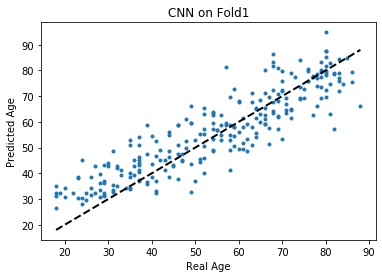

Fold 1
+ TRAINING 	Epoch: 1 	Loss: 805.306470
--------------------------------------------------
+ VALIDATE 	Epoch: 1 	Loss: 451.545064
--------------------------------------------------
+ TRAINING 	Epoch: 2 	Loss: 415.066386
+ TRAINING 	Epoch: 3 	Loss: 367.808231
+ TRAINING 	Epoch: 4 	Loss: 321.605613
+ TRAINING 	Epoch: 5 	Loss: 263.639579
+ TRAINING 	Epoch: 6 	Loss: 207.748990
+ TRAINING 	Epoch: 7 	Loss: 160.754364
+ TRAINING 	Epoch: 8 	Loss: 131.326689
+ TRAINING 	Epoch: 9 	Loss: 116.016028
+ TRAINING 	Epoch: 10 	Loss: 108.428070
--------------------------------------------------
+ VALIDATE 	Epoch: 10 	Loss: 96.463330
--------------------------------------------------
+ TRAINING 	Epoch: 11 	Loss: 103.907696
+ TRAINING 	Epoch: 12 	Loss: 100.235336
+ TRAINING 	Epoch: 13 	Loss: 96.432457
+ TRAINING 	Epoch: 14 	Loss: 93.402950
+ TRAINING 	Epoch: 15 	Loss: 90.324658
+ TRAINING 	Epoch: 16 	Loss: 87.834343
+ TRAINING 	Epoch: 17 	Loss: 84.904971
+ TRAINING 	Epoch: 18 	Loss: 82.299276
+ TRAI

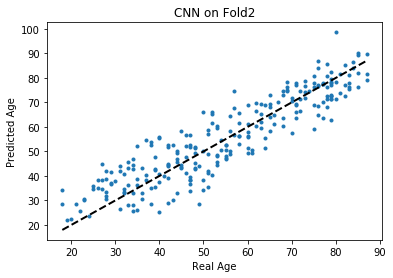


Finished TRAINING.


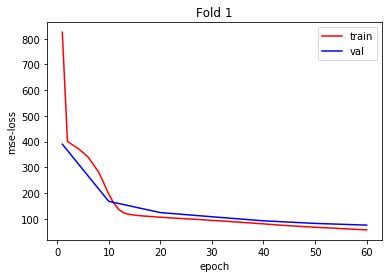

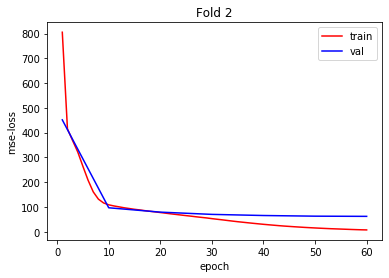

In [ ]:
# Training and Validation
model_dir = os.path.join(out_dir, 'model')
if not os.path.exists(model_dir):
    os.makedirs(model_dir)

torch.manual_seed(rnd_seed) # fix random seed

# Losses
loss_train_epoch_log = []
loss_train_batch_log = []
loss_val_log = []
loss_val_epoch_log = []
epoch_val = []
  

print('START TRAINING...')
for fold in range(2):
  # Reset model for each fold
  # Model setup
  model = LeNetRegressor().to(device)

  # Optimiser
  optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

  # Fold index: training set
  tr_fold_ind = fold
  val_fold_ind = -1
  if tr_fold_ind == 1:
    val_fold_ind = 0
  else:
    val_fold_ind = 1
  
  print(f'Fold {fold}')
  loss_train_epoch_log_fold = []
  loss_train_batch_log_fold = []
  loss_val_log_fold = []
  loss_val_epoch_log_fold = []
  epoch_val_fold = []

  for epoch in range(1, num_epochs+1):
      # Training
      model.train()
      training_loss = 0
      for batch_idx, batch_samples in enumerate(cv_dataloader[tr_fold_ind]):
          gm = batch_samples.to(device)
          optimizer.zero_grad()
          age_pred = model(gm)
          age_pred = age_pred.view(age_pred.size(0), age_pred.size(1), -1)
          loss = F.mse_loss(age_pred, cv_y[tr_fold_ind][:,:,batch_idx,:])
          loss_train_batch_log_fold.append(loss.item())
          training_loss += loss.item()
          loss.backward()
          optimizer.step()
      loss_train_epoch_log_fold.append(training_loss/250)

      print('+ TRAINING \tEpoch: {} \tLoss: {:.6f}'.format(epoch, training_loss/250))
      
      # Validation
      if epoch == 1 or epoch % val_interval == 0:
          model.eval()
          loss_val = 0
          sum_pts = 0
          validation_loss = 0
          with torch.no_grad():
              for idx, data_sample in enumerate(cv_dataloader[val_fold_ind]):
                  gm = data_sample.to(device)
                  age_pred = model(gm)
                  age_pred = age_pred.view(age_pred.size(0), age_pred.size(1), -1)
                  loss_val = F.mse_loss(age_pred, cv_y[val_fold_ind][:,:,idx,:]).item()
                  loss_val_log_fold.append(loss_val)
                  validation_loss += loss_val

          epoch_val_fold.append(epoch)
          loss_val_epoch_log_fold.append(validation_loss/250)

          print('--------------------------------------------------')
          print('+ VALIDATE \tEpoch: {} \tLoss: {:.6f}'.format(epoch, validation_loss/250))
          print('--------------------------------------------------')

      # Display scatter plot
      if epoch == num_epochs:
        model.eval()
        val_age_pred = []
        val_y = []
        with torch.no_grad():
            for idx, data_sample in enumerate(cv_dataloader[val_fold_ind]):
                  gm = data_sample.to(device)
                  age_pred = model(gm)
                  age_pred = age_pred.view(age_pred.size(0), age_pred.size(1), -1)
                  val_age_pred.append(age_pred)
                  val_y.append(cv_y[val_fold_ind][:,:,idx,:])
        val_y = torch.Tensor(val_y)
        val_age_pred = torch.Tensor(val_age_pred)

        display_performance(val_y, val_age_pred, 'CNN on Fold'+ str(fold + 1))
  loss_train_epoch_log.append(loss_train_epoch_log_fold)
  loss_train_batch_log.append(loss_train_batch_log_fold)
  loss_val_log.append(loss_val_log_fold)
  loss_val_epoch_log.append(loss_val_epoch_log_fold)
  epoch_val.append(epoch_val_fold)


print('\nFinished TRAINING.')
plt.figure()
plt.plot(range(1, num_epochs + 1), loss_train_epoch_log[0], c='r', label='train')
plt.plot(epoch_val[0], loss_val_epoch_log[0], c='b', label='val')
plt.legend(loc='upper right')
plt.xlabel('epoch')
plt.ylabel('mse-loss')
plt.title('Fold 1')
plt.show()

plt.figure()
plt.plot(range(1, num_epochs + 1), loss_train_epoch_log[1], c='r', label='train')
plt.plot(epoch_val[1], loss_val_epoch_log[1], c='b', label='val')
plt.legend(loc='upper right')
plt.xlabel('epoch')
plt.ylabel('mse-loss')
plt.title('Fold 2')
plt.show()

In [ ]:
# Dataset
dataset_train = ConvRegressionDataset(files_gm_train, img_spacing, img_size=None)
train_dataloader = torch.utils.data.DataLoader(dataset_train, batch_size=1, shuffle = False)
age_train = meta_data_reg_train['age'].values.reshape(-1,1)
age_train = torch.FloatTensor(age_train).unsqueeze(0).unsqueeze(0).to(device)

# Train the final model using the entire dataset
# Model setup
final_model = LeNetRegressor().to(device)

# Optimiser
optimizer = torch.optim.Adam(final_model.parameters(), lr=learning_rate)
final_training_log_loss = []
final_model.train()

for epoch in range(0, num_epochs):
  training_loss = 0
  # Training
  for batch_idx, batch_samples in enumerate(train_dataloader):
    gm = batch_samples.to(device)
    optimizer.zero_grad()
    age_pred = final_model(gm)
    age_pred = age_pred.view(age_pred.size(0), age_pred.size(1), -1)
    
    loss = F.mse_loss(age_pred, age_train[:,:,batch_idx,:])
    loss.backward()
    training_loss += loss.item()
    optimizer.step()
  final_training_log_loss.append(training_loss/500)
  print('+ TRAINING \tEpoch: {}: average training loss: {:.6f}'.format(epoch, training_loss/500))

Loading Data: 100%|██████████| 500/500 [00:07<00:00, 66.49it/s]


+ TRAINING 	Epoch: 0: average training loss: 615.507521
+ TRAINING 	Epoch: 1: average training loss: 356.596346
+ TRAINING 	Epoch: 2: average training loss: 314.580159
+ TRAINING 	Epoch: 3: average training loss: 211.196478
+ TRAINING 	Epoch: 4: average training loss: 120.145045
+ TRAINING 	Epoch: 5: average training loss: 109.116486
+ TRAINING 	Epoch: 6: average training loss: 103.924199
+ TRAINING 	Epoch: 7: average training loss: 100.636755
+ TRAINING 	Epoch: 8: average training loss: 97.634762
+ TRAINING 	Epoch: 9: average training loss: 94.652918
+ TRAINING 	Epoch: 10: average training loss: 91.838836
+ TRAINING 	Epoch: 11: average training loss: 88.985052
+ TRAINING 	Epoch: 12: average training loss: 86.088170
+ TRAINING 	Epoch: 13: average training loss: 83.146515
+ TRAINING 	Epoch: 14: average training loss: 80.073265
+ TRAINING 	Epoch: 15: average training loss: 76.904502
+ TRAINING 	Epoch: 16: average training loss: 73.641184
+ TRAINING 	Epoch: 17: average training loss: 70.3

In [ ]:
torch.save(final_model.state_dict(), os.path.join(model_dir, 'model.pt'))

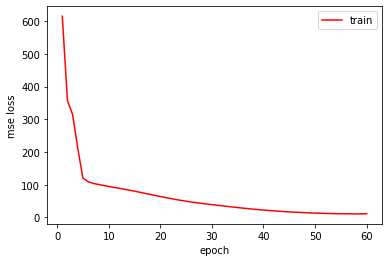

In [ ]:
# Loss PLot
plt.plot(range(1, num_epochs +1), final_training_log_loss, c='r', label='train')
plt.legend(loc='upper right')
plt.xlabel('epoch')
plt.ylabel('mse loss')
plt.show()

In [ ]:
# Testing
meta_data_reg_test = pd.read_csv(data_dir + 'meta/meta_data_reg_test.csv')
ids_gm_test = list(meta_data_reg_test['subject_id'])
files_gm_test = [data_dir + 'greymatter/wc1sub-' + f + '_T1w.nii.gz' for f in ids_gm_test]

dataset_test = ConvRegressionDataset(files_gm_test, img_spacing, img_size=None)
test_dataloader = torch.utils.data.DataLoader(dataset_test, batch_size=1, shuffle = False)
age_test_label = meta_data_reg_test['age'].values.reshape(-1,1)
age_test_label = torch.FloatTensor(age_test_label).unsqueeze(0).unsqueeze(0).to(device)

pred_dir = os.path.join(out_dir, 'pred')
if not os.path.exists(pred_dir):
    os.makedirs(pred_dir)

model = LeNetRegressor()
model.load_state_dict(torch.load(os.path.join(model_dir, 'model.pt')))
model.to(device)
model.eval()
    
print('START TESTING...')

loss_test = 0
sum_pts = 0
idx_test = 0
with torch.no_grad():
    for idx_test, data_sample in enumerate(test_dataloader):
        test = data_sample.to(device)
        age_pred_test = model(test)
        age_pred_test = age_pred_test.view(age_pred_test.size(0), age_pred_test.size(1), -1)
        loss_test += F.mse_loss(age_pred_test, age_test_label[:,:,idx_test,:]).item()
        sum_pts += 1
        idx_test += 1
        
loss_test /= sum_pts

print('+ TESTING \tLoss: {:.6f}'.format(loss_test))

print('\nFinished TESTING.')

Loading Data: 100%|██████████| 100/100 [00:01<00:00, 66.48it/s]


START TESTING...
+ TESTING 	Loss: 58.072018

Finished TESTING.


Error calculation and plotting

In [ ]:
# Test predicitions
model.eval()
age_pred_test = torch.zeros([len(dataloader_test), 1])
with torch.no_grad():
    for i, data_sample in enumerate(test_dataloader):
        test = data_sample.to(device)
        print(model(test))
        age_pred_test[i,0] = model(test)

tensor([[[[[45.5763]]]]], device='cuda:0')
tensor([[[[[23.3460]]]]], device='cuda:0')
tensor([[[[[76.0854]]]]], device='cuda:0')
tensor([[[[[66.6848]]]]], device='cuda:0')
tensor([[[[[40.0354]]]]], device='cuda:0')
tensor([[[[[48.4384]]]]], device='cuda:0')
tensor([[[[[69.4709]]]]], device='cuda:0')
tensor([[[[[61.4752]]]]], device='cuda:0')
tensor([[[[[75.0269]]]]], device='cuda:0')
tensor([[[[[34.8361]]]]], device='cuda:0')
tensor([[[[[53.7842]]]]], device='cuda:0')
tensor([[[[[40.1626]]]]], device='cuda:0')
tensor([[[[[46.0851]]]]], device='cuda:0')
tensor([[[[[43.8357]]]]], device='cuda:0')
tensor([[[[[69.7553]]]]], device='cuda:0')
tensor([[[[[72.1556]]]]], device='cuda:0')
tensor([[[[[28.0027]]]]], device='cuda:0')
tensor([[[[[68.4241]]]]], device='cuda:0')
tensor([[[[[76.0690]]]]], device='cuda:0')
tensor([[[[[62.7544]]]]], device='cuda:0')
tensor([[[[[59.5598]]]]], device='cuda:0')
tensor([[[[[45.3584]]]]], device='cuda:0')
tensor([[[[[65.2378]]]]], device='cuda:0')
tensor([[[[

mean absolute error: 6.119724273681641
r2 score: 0.8464328474840702


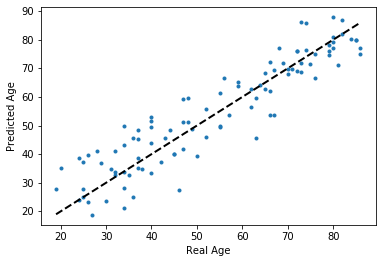

In [ ]:
# Test set evaluation and scatter plot
print('mean absolute error: {0}'.format(torch.mean(torch.abs(age_test_label.cpu() - age_pred_test.cpu()))))
print('r2 score: {0}'.format(r2_score(age_test_label[0,0,:,:].cpu(),age_pred_test.cpu())))

fig, ax = plt.subplots()
ax.scatter(age_test_label.cpu(), age_pred_test.cpu(), marker='.')
ax.plot([age_test_label.cpu().min(), age_test_label.cpu().max()], [age_test_label.cpu().min(), age_test_label.cpu().max()], 'k--', lw=2)
ax.set_xlabel('Real Age')
ax.set_ylabel('Predicted Age')
plt.show()